In [1]:
from mlxtend.data import loadlocal_mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import numpy as np 
import torch
import ANN
import CNN 
from torchmetrics import Accuracy,F1Score
from PIL import Image,ImageDraw,ImageFont
from torch.utils.data import TensorDataset, DataLoader

Constants

In [2]:
train_img_path = './data/train-images.idx3-ubyte'
train_lbl_path = './data/train-labels.idx1-ubyte'
test_img_path = './data/t10k-images.idx3-ubyte'
test_lbl_path = './data/t10k-labels.idx1-ubyte'


BATCH_SIZE = 32
EPOCHS = 40

In [3]:
def show_plots(metrics):
    fig,axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].plot(metrics['loss'],label=f'train - {metrics['loss'][-1]:.2f}')
    axs[0].plot(metrics['val_loss'],label=f'valdiation - {metrics['val_loss'][-1]:.2f}')
    axs[0].legend()
    axs[0].set_title("Loss")

    axs[1].plot(metrics['acc'],label=f'train - {metrics['acc'][-1]:.2f}')
    axs[1].plot(metrics['val_acc'],label=f'validation - {metrics['val_acc'][-1]:.2f}')
    axs[1].legend()
    axs[1].set_title("Accuracy")

    axs[2].plot(metrics['f1'],label=f'train - {metrics['f1'][-1]:.2f}')
    axs[2].plot(metrics['val_f1'],label=f'validation - {metrics['val_f1'][-1]:.2f}')
    axs[2].legend()
    axs[2].set_title("F1_Score")

In [4]:
def show_samples(imgs,y=[],y_hat=[]):
    rows = 3
    cols = 3 
    
    img_h = imgs.shape[1] * 3 
    img_w = imgs.shape[2] * 3 
    
    H =  img_h*rows 
    W =  img_w*cols
    
    grid = Image.new('RGB',(H,W),'black')
    draw = ImageDraw.Draw(grid)
    font = ImageFont.load_default(20)
    font_length = font.getlength('9')
    
    for i,img in enumerate(imgs):
        img = Image.fromarray(img).resize((img_h,img_w))
        top = i%rows*img_h
        left = i//cols*img_w
        grid.paste(img,(left,top))
        
        if y and y_hat:
            color = (255,0,0)
            if y[i] == y_hat[i]:
                color = (0,255,0)
            
            draw.text((left,top,left+font_length,top),f'{y_hat[i]}',color,font=font)
    return grid

In [5]:
# Shows random images and related predicted labels by given model
def show_from(dset,model):
    random_point = np.random.randint(0,len(dset),1).item()
    random_samples = dset[random_point:random_point+9]
    
    imgs = random_samples[0]
    lbls = random_samples[1]

    with torch.no_grad():
        pred = torch.argmax(model(imgs),-1)
    
    random_imgs = imgs.numpy().reshape(imgs.shape[0],28,28) * 255 
    random_lbls = lbls.tolist()
    random_pred = pred.tolist()
    return show_samples(random_imgs,random_lbls,random_pred)

Preparing data loader for ANN

In [6]:
X,Y = loadlocal_mnist(train_img_path,train_lbl_path)

Xtrain,Xval,Ytrain,Yval = train_test_split(X,Y,test_size=0.2,random_state=101)
Xtest,Ytest = loadlocal_mnist(test_img_path,test_lbl_path)

print(f'Train size: {Xtrain.shape}')
print(f'Validation size: {Xval.shape}')
print(f'Test size: {Xtest.shape}')

Train size: (48000, 784)
Validation size: (12000, 784)
Test size: (10000, 784)


In [7]:
trainset = TensorDataset(torch.from_numpy(Xtrain)/255.,torch.from_numpy(Ytrain).to(torch.long))
valset = TensorDataset(torch.from_numpy(Xval)/255.,torch.from_numpy(Yval).to(torch.long))
testset = TensorDataset(torch.from_numpy(Xtest)/255.,torch.from_numpy(Ytest).to(torch.long))

In [8]:
train_loader = DataLoader(trainset,BATCH_SIZE,True)
val_loader = DataLoader(valset,BATCH_SIZE,True)
test_loader = DataLoader(testset,BATCH_SIZE,False)

Destribution of labels

<BarContainer object of 10 artists>

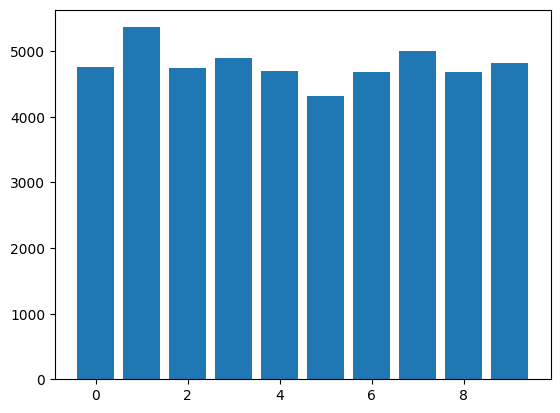

In [9]:
dest = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
for n in Ytrain:
    dest[n] += 1 
plt.bar(dest.keys(),dest.values())

Showing some random samples

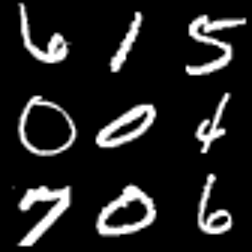

In [10]:
rand_nums= np.random.randint(0,Xtrain.shape[0],9)
samples = np.array([Xtrain[n].reshape(28,28) for n in rand_nums])
show_samples(samples)

Prepare training and evaluation loops

In [11]:
def train_step(loader,model,optim,criterion,acc,f1):
    model.train()
    total_loss = 0 
    for i,(imgs,labels) in enumerate(loader):
        optim.zero_grad(True)
        logits = model(imgs)
        loss = criterion(logits,labels)
        loss.backward()
        optim.step()
        
        acc.update(logits,labels)
        f1.update(logits,labels)
        total_loss += loss
    
    total_loss /= (i+1)
    total_acc = acc.compute()
    total_f1 = f1.compute()
    
    f1.reset()
    acc.reset()
    return total_loss,total_acc,total_f1

In [12]:
def val_step(loader,model,criterion,acc,f1):
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for i,(imgs,labels) in enumerate(loader):
            logits = model(imgs)
            loss = criterion(logits,labels)
            acc.update(logits,labels)
            f1.update(logits,labels)
            total_loss += loss
        
        total_loss /= (i+1)
        total_acc = acc.compute()
        total_f1 = f1.compute()
        
        f1.reset()
        acc.reset()
    return total_loss,total_acc,total_f1

# Test on ANN

In [13]:
ann = ANN.Model(Xtrain.shape[1])

optimizer = torch.optim.SGD(ann.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()
accuracy = Accuracy('multiclass',num_classes=10)
f1_score = F1Score('multiclass',num_classes=10)

print(f"Trainable Params: {sum([p.numel() for p in ann.parameters() if p.requires_grad])}")

Trainable Params: 7298


In [14]:
metrics = {'loss':[],'val_loss':[],'acc':[],'val_acc':[],'f1':[],'val_f1':[]}

for epoch in range(EPOCHS):
    loss,train_acc,train_f1 = train_step(train_loader,ann,optimizer,criterion,accuracy,f1_score)
    val_loss,val_acc,val_f1 = val_step(val_loader,ann,criterion,accuracy,f1_score)
    
    metrics['loss'].append(loss.item())
    metrics['val_loss'].append(val_loss.item())
    metrics['acc'].append(train_acc.item())
    metrics['val_acc'].append(val_acc.item())
    metrics['f1'].append(train_f1.item())
    metrics['val_f1'].append(val_f1.item())
    

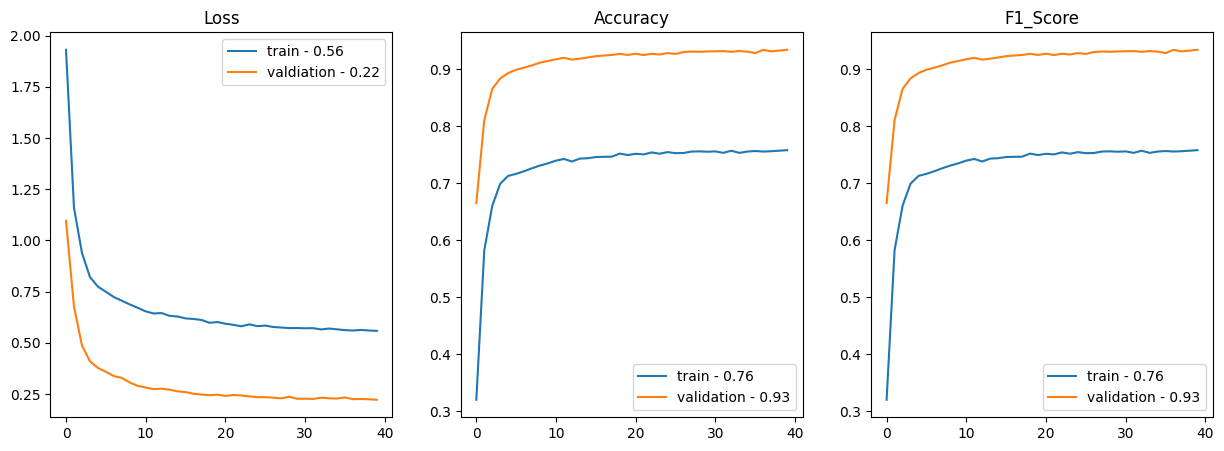

In [15]:
show_plots(metrics)

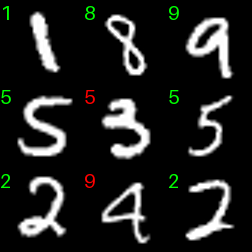

In [16]:
show_from(testset,ann)

In [17]:
test_loss,test_acc,test_f1 = val_step(test_loader,ann,criterion,accuracy,f1_score)
print(f"Results on unseen data:\n\t- Loss: {test_loss.item():.2f}\n\t- Accuracy: {test_acc.item():.2f}\n\t- F1 Score: {test_f1.item():.2f}")

Results on unseen data:
	- Loss: 0.20
	- Accuracy: 0.94
	- F1 Score: 0.94


# Test on CNN

Preparing data for CNNs

In [18]:
reshaped_x_train = Xtrain.reshape(48000,1,28,28)/255.
reshaped_x_val = Xval.reshape(12000,1,28,28)/255.
reshaped_x_test = Xtest.reshape(10000,1,28,28)/255.

In [19]:
trainset = TensorDataset(torch.from_numpy(reshaped_x_train).to(torch.float),torch.from_numpy(Ytrain).to(torch.long))
valset = TensorDataset(torch.from_numpy(reshaped_x_val).to(torch.float),torch.from_numpy(Yval).to(torch.long))
testset = TensorDataset(torch.from_numpy(reshaped_x_test).to(torch.float),torch.from_numpy(Ytest).to(torch.long))

In [20]:
train_loader = DataLoader(trainset,BATCH_SIZE,True)
val_loader = DataLoader(valset,BATCH_SIZE,True)
test_loader = DataLoader(testset,BATCH_SIZE,False)

Train the CNN

In [21]:
cnn = CNN.Model(1)

optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()
accuracy = Accuracy('multiclass',num_classes=10)
f1_score = F1Score('multiclass',num_classes=10)

print(f"Trainable Params: {sum([p.numel() for p in cnn.parameters() if p.requires_grad])}")

Trainable Params: 12810


In [22]:
metrics = {'loss':[],'val_loss':[],'acc':[],'val_acc':[],'f1':[],'val_f1':[]}

for epoch in range(EPOCHS):
    loss,train_acc,train_f1 = train_step(train_loader,cnn,optimizer,criterion,accuracy,f1_score)
    val_loss,val_acc,val_f1 = val_step(val_loader,cnn,criterion,accuracy,f1_score)
    
    metrics['loss'].append(loss.item())
    metrics['val_loss'].append(val_loss.item())
    metrics['acc'].append(train_acc.item())
    metrics['val_acc'].append(val_acc.item())
    metrics['f1'].append(train_f1.item())
    metrics['val_f1'].append(val_f1.item())
    

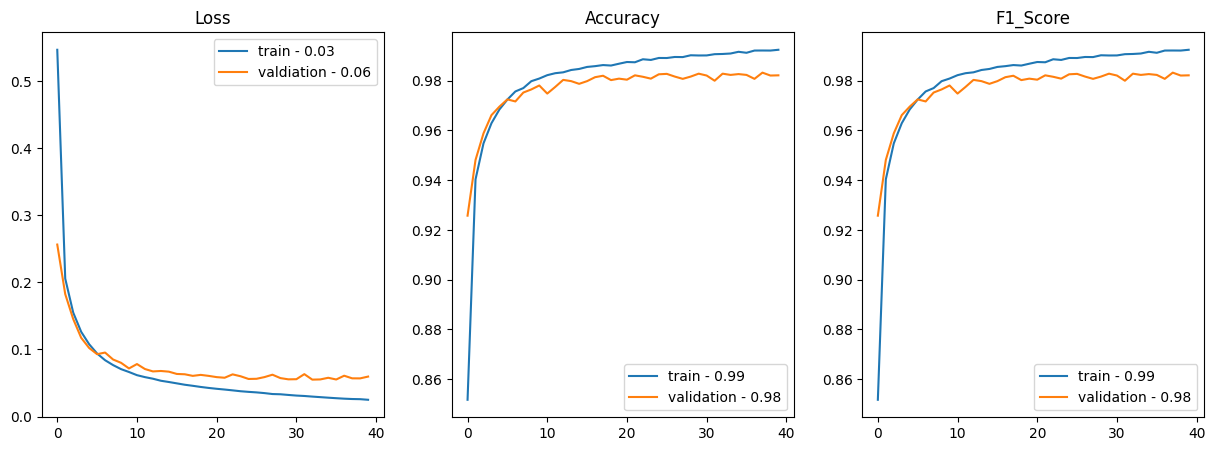

In [23]:
show_plots(metrics)

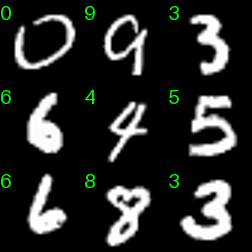

In [24]:
show_from(testset,cnn)

In [25]:
test_loss,test_acc,test_f1 = val_step(test_loader,cnn,criterion,accuracy,f1_score)
print(f"Results on unseen data:\n\t- Loss: {test_loss.item():.2f}\n\t- Accuracy: {test_acc.item():.2f}\n\t- F1 Score: {test_f1.item():.2f}")

Results on unseen data:
	- Loss: 0.05
	- Accuracy: 0.98
	- F1 Score: 0.98
